# Nearest Neighbor (NN)

### Concept:
The **Nearest Neighbor (NN)** algorithm identifies the single closest data point to a query point \( q \) based on a specified distance metric.

### Steps:
1. **Query Point**: A new or unknown data point that we want to analyze or label. Represent the query point as:
   $$ q = (q_1, q_2, \dots, q_d) $$
   where \( d \) is the number of dimensions.

2. **Data Points**: we have a dataset X of labeled points. Let \( n \) data points be represented as:
   $$ X = \{x^{(1)}, x^{(2)}, \dots, x^{(n)}\} $$
   where each data point \( x^{(i)} \) is \( d \)-dimensional:
   $$ x^{(i)} = (x_1^{(i)}, x_2^{(i)}, \dots, x_d^{(i)}) $$

3. **Distance Calculation**: Compute the distance \( d(q, x^{(i)}) \) for each \( i \). Using **Euclidean Distance** as an example:
   $$ d(q, x^{(i)}) = \sqrt{\sum_{j=1}^d \big(q_j - x_j^{(i)}\big)^2} $$

4. **Find the Nearest Neighbor**: Identify the data point \( x^{(i)} \) with the smallest distance and choose its label for that query:
   $$ x_{\text{NN}} = \arg\min_{x \in X} d(q, x) $$

---

Nearest neighbours is sensitive to noise or mis-labeled data. Solution?

---
# k-Nearest Neighbors (kNN)

### Concept:
The **k-Nearest Neighbors (kNN)** algorithm finds the \( k \) closest data points to \( q \), then uses these neighbors to determine the label (classification) or value (regression) of \( q \).

### Steps:
1. **Query Point**: Same as NN:
   $$ q = (q_1, q_2, \dots, q_d) $$

2. **Data Points**: Same as NN:
   $$ X = \{x^{(1)}, x^{(2)}, \dots, x^{(n)}\} $$

3. **Distance Calculation**: Compute the distance \( d(q, x^{(i)}) \) for all \( x^{(i)} \in X \):
   $$ d(q, x^{(i)}) = \sqrt{\sum_{j=1}^d \big(q_j - x_j^{(i)}\big)^2} $$

4. **Sort Distances**: Rank the distances in ascending order:
   $$ d(q, x^{(i_1)}) \leq d(q, x^{(i_2)}) \leq \dots \leq d(q, x^{(i_n)}) $$

5. **Select \( k \) Neighbors**: Choose the \( k \) smallest distances, corresponding to:
   $$ \{x^{(i_1)}, x^{(i_2)}, \dots, x^{(i_k)}\} $$

6. **Decision**:
   - **Classification**: Assign \( q \) the majority class among the \( k \) neighbors:
     $$ \text{Class}(q) = \text{mode}\big(\text{Class}(x^{(i_1)}), \dots, \text{Class}(x^{(i_k)})\big) $$
   - **Regression**: Assign \( q \) the average value of the \( k \) neighbors:
     $$ \text{Value}(q) = \frac{1}{k} \sum_{j=1}^k \text{Value}(x^{(i_j)}) $$


---
Python Practice
---
We will use the scikit-learn’s KNN classifier to classify patients into liver patient (liver disease) or not (no disease). 

We will use a dataset of 416 liver patient records and 167 non liver patient records collected from North East of Andhra Pradesh, India. 10 variables for each patient are recorded, and the true label is in column Dataset. The data is obtained through https://www.kaggle.com/datasets/uciml/indian-liver-patient-records. We will use the data stored in HW1_data.csv on the course website for this assignment.
You will build a KNN classifier to classify patients into liver patient (liver disease) or not (no disease).


In [72]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler,  LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
# setting random seed for reproducibility
np.random.seed(1210)

In [73]:
# path to data
data_path = "/Users/ahmadreza/Documents/Files/PhD Files/code/code_repository/algorithms/KNN/hw1_data.csv"

In [74]:
# Function for loading the data
def load_data(data_path: str) -> tuple[list, list, list]:
    # Load the dataset from the given CSV file
    df = pd.read_csv(data_path)
    
    # Initialize the encoder for categorical 'Gender' feature
    label_encoder = LabelEncoder()
    # Encode the 'Gender' column (Male: 0, Female: 1)
    df['Gender'] = label_encoder.fit_transform(df['Gender'])
    
    # Extract target labels from 'Dataset' column
    y = df["Dataset"].to_numpy()
    
    # Drop the target column from the feature set
    df = df.drop(columns=["Dataset"])
    
    # Convert features to numpy array
    X = df.to_numpy()
    
    # Handle NaN values by replacing them with 0
    X = np.nan_to_num(X)
    
    # Split the dataset into training + validation and testing sets (80% train + validation, 20% test)
    train_val_X, test_X, train_val_y, test_y = train_test_split(X, y, test_size=0.20)
    
    # Split the training + validation set into train and validation sets (90% train, 10% validation)
    train_X, val_X, train_y, val_y = train_test_split(train_val_X, train_val_y, test_size=(0.10/0.80))
    
    # Return the train, validation, and test sets as tuples
    return [train_X, train_y], [val_X, val_y], [test_X, test_y]


In [75]:
# Load data
train, val, test = load_data(data_path)
ks = list(range(1, 21))  # Define a range of k values (1 to 20) to test in k-NN

In [76]:
def plot_knns(ks,train_accs,val_accs):
  plt.plot(ks,train_accs,label="train")
  plt.plot(ks,val_accs,label="validation")
  plt.xlabel("k")
  plt.xticks(ks)
  plt.ylabel("accuracy")
  plt.legend()
  plt.show()

In [82]:
def plot_voronoi_diagram(
        best_model: KNeighborsClassifier,
        train: tuple[list, list],
        standardization: bool = True
        ) -> None:

    # Extract the best model and its training data
    train_X, train_y = train[0], train[1]

    # If standardization was applied, use the standardized data
    if standardization:
        scaler = StandardScaler().fit(train_X)
        train_X = scaler.transform(train_X)    
     
    # Ensure the data is 2D (for Voronoi diagram)
    if train_X.shape[1] < 2:
        raise ValueError("Voronoi diagram can only be plotted for 2D data. ")
    
    elif train_X.shape[1] > 2:
        pca = PCA(n_components=2)
        train_X = pca.fit_transform(train_X)

    # Fit the model to the 2D data
    best_model.fit(train_X, train_y)

    # Create a grid for decision boundary visualization
    x_min, x_max = train_X[:, 0].min() - 1, train_X[:, 0].max() + 1
    y_min, y_max = train_X[:, 1].min() - 1, train_X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    # Predict class for each point in the grid
    Z = best_model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary
    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Paired)

    # Plot the training points
    scatter = plt.scatter(train_X[:, 0], train_X[:, 1], c=train_y, cmap=plt.cm.Paired, edgecolor='k', s=50)
    plt.legend(*scatter.legend_elements(), title="Classes")

    # Generate and plot Voronoi diagram
    vor = Voronoi(train_X)  # Create Voronoi diagram
    voronoi_plot_2d(vor, ax=plt.gca(), show_vertices=False, line_colors='orange', line_width=1)

    # Label axes and add title
    plt.xlabel(f"Feature 1")
    plt.ylabel(f"Feature 2")
    plt.title("Voronoi Diagram and Decision Boundaries")
    plt.show()


In [78]:
# Function to select the best k-NN model
def select_knn_model(
        ks: list[int],  # List of k values to test
        train: tuple[list, list],  # Training data and labels
        val: tuple[list, list],  # Validation data and labels
        test: tuple[list, list],  # Test data and labels
        metric: str = 'minkowski',  # Distance metric for k-NN (default: minkowski)
        standardization: bool = True  # Whether to standardize data (default: True)
) -> KNeighborsClassifier:
    # Extract data and labels for training, validation, and testing
    train_X, train_y = train[0], train[1]
    val_X, val_y = val[0], val[1]
    test_X, test_y = test[0], test[1]

    # If standardization is enabled, scale the features to have zero mean and unit variance
    if standardization:
        scaler = StandardScaler().fit(train_X)  # Fit scaler on training data
        train_X = scaler.transform(train_X)  # Apply transformation to training data
        val_X = scaler.transform(val_X)  # Apply transformation to validation data
        test_X = scaler.transform(test_X)  # Apply transformation to test data

    models, train_accs, val_accs = [], [], []  # Initialize lists to store models and accuracies

    # Loop through each k value and train the k-NN model
    for k in ks:
        knn = KNeighborsClassifier(n_neighbors=k, metric=metric)  # Initialize k-NN classifier
                
        knn.fit(train_X, train_y)  # Train the k-NN model on the training data

        models.append(knn)  # Append the trained model to the models list
        train_accs.append(knn.score(train_X, train_y))  # Append training accuracy
        val_accs.append(knn.score(val_X, val_y))  # Append validation accuracy

    # Convert accuracies to numpy arrays for plotting
    ks = np.array(ks)
    train_accs = np.array(train_accs)
    val_accs = np.array(val_accs)

    # Plot the accuracies for different values of k
    plot_knns(ks, train_accs, val_accs)

    # Find the best k (i.e., the k with the highest validation accuracy)
    best_k = ks[np.argmax(val_accs)]
    best_train_acc = train_accs[np.argmax(val_accs)]  # Best training accuracy
    best_val_acc = val_accs[np.argmax(val_accs)]  # Best validation accuracy
    best_test_acc = models[np.argmax(val_accs)].score(test_X, test_y)  # Test accuracy of the best model

    # Print the best model's k, training accuracy, validation accuracy, and test accuracy
    print(f"> best model: k = {best_k}, train_acc = {best_train_acc}, val_acc = {best_val_acc}, test_acc = {best_test_acc}")

    return models[np.argmax(val_accs)]

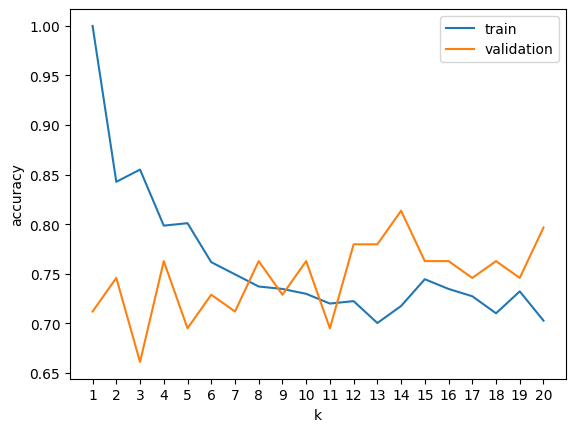

> best model: k = 14, train_acc = 0.7174447174447175, val_acc = 0.8135593220338984, test_acc = 0.6923076923076923


In [79]:
best_model = select_knn_model(
    ks, 
    train,
    val,
    test,
    'minkowski',
    True
)

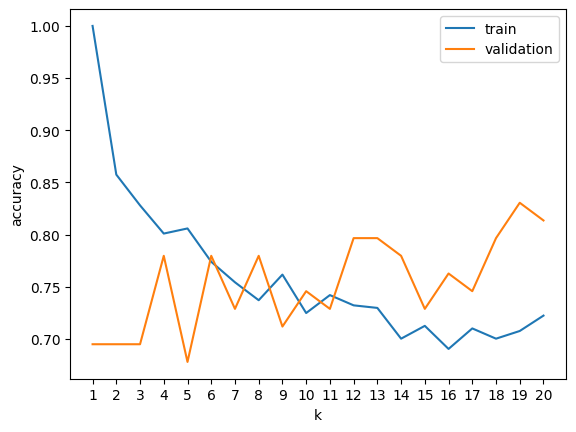

> best model: k = 19, train_acc = 0.7076167076167076, val_acc = 0.8305084745762712, test_acc = 0.7435897435897436


In [80]:
best_model = select_knn_model(
    ks, 
    train,
    val,
    test,
    'cosine',
    True
)

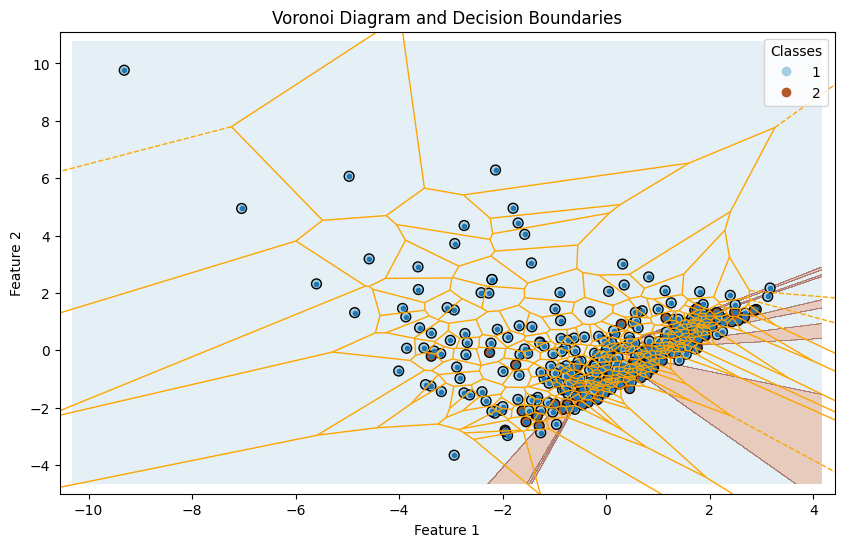

In [83]:
# Plot the Voronoi diagram
plot_voronoi_diagram(best_model, train, True)
